# Validation of the PyPSA-Africa Electric Demand

This notebooks investigates the data quality of the African electric consumption
data by comparing PyPSA, official Nigerian and Our World in Data (incl. BP & Ember).

To reproduce the findings obtained in this notebook,
please run the full snakemake workflow for the Africa.
To do so, please set ``countries = ["Africa"]`` in the ``config.yaml`` file.

Note. An unoptimized prepared network is sufficient for this notebook. 

## Preparation

### Import packages

In [1]:
# import packages

import logging
import os

import pypsa
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

logger = logging.getLogger(__name__)

pd.set_option("display.max_columns", None)
pd.set_option("display.max_colwidth", 70)

### Set main directory to root folder

In [2]:
# change current directory
import os
import sys

module_path = os.path.abspath(os.path.join('../../../')) # To import helpers
if module_path not in sys.path:
    sys.path.append(module_path+"/pypsa-earth/scripts")
    
from _helpers import sets_path_to_root, three_2_two_digits_country, two_2_three_digits_country

sets_path_to_root("pypsa-earth-project")

This is the repository path:  /home/anas/EDF/pypsa-earth-project
Had to go 3 folder(s) up.


## 1. Load data 

#### Our World in Data
Retrieved from their GitHub: https://github.com/owid/energy-data/tree/master \
Web interface: https://ourworldindata.org/energy 

Our data sources:
- Energy consumption (primary energy, energy mix and energy intensity): this data is sourced from a combination of three sources—the BP Statistical Review of World Energy, the EIA and the SHIFT Data Portal.
- Electricity generation (electricity generation, and electricity mix): this data is sourced from a combination of three sources—the BP Statistical Review of World Energy, the Ember – Data Explorer and the Ember European Electricity Review.
- Other variables: this data is collected from a variety of sources (United Nations, World Bank, Gapminder, Maddison Project Database, etc.). More information is available in our codebook.


In [3]:
url = "https://nyc3.digitaloceanspaces.com/owid-public/data/energy/owid-energy-data.csv"
df = pd.read_csv(url)
df = df.loc[:, ["iso_code", "country", "year", "electricity_demand"]]
df = df[df["iso_code"].notna()]  # removes antartica
df["iso_code_2"] = df.loc[:, "iso_code"].apply(lambda x: three_2_two_digits_country(x))
electricity_demand_owid = df
electricity_demand_owid.tail(2)

,iso_code,country,year,electricity_demand,iso_code_2
22341,ZWE,Zimbabwe,2020,12.22,ZW
22342,ZWE,Zimbabwe,2021,NaN,ZW


#### PyPSA network

Requires a solved or unsolved network.

In [4]:
solved_network_path = os.getcwd() + "/pypsa-earth/networks/elec_s_10_ec.nc"
pypsa_network = pypsa.Network(solved_network_path)
electricity_demand_pypsa = pypsa_network.loads_t.p_set
electricity_demand_pypsa.head(2)

INFO:pypsa.io:Imported network elec_s_10_ec.nc has buses, carriers, generators, lines, links, loads, storage_units, stores


Load,NGA.10_1,NGA.12_1,NGA.14_1,NGA.15_1,NGA.16_1,NGA.19_1,NGA.1_1,NGA.20_1,NGA.21_1,NGA.22_1,NGA.23_1,NGA.25_1,NGA.27_1,NGA.28_1,NGA.29_1,NGA.2_1,NGA.30_1,NGA.31_1,NGA.32_1,NGA.33_1,NGA.34_1,NGA.36_1,NGA.37_1,NGA.3_1,NGA.4_1,NGA.5_1,NGA.7_1,NGA.8_1,NGA.9_1
snapshot,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2013-01-01 00:00:00,171.636469,183.434942,145.461545,91.689344,52.196037,83.509802,138.499636,196.795098,19.669185,11.047674,105.965850,657.244957,221.740007,121.027485,49.542947,41.728214,233.168879,155.677223,101.530133,368.280968,9.490249,6.662394,25.384086,93.485203,238.315408,13.515900,66.719220,58.978952,97.212018
2013-01-01 01:00:00,175.817140,187.902997,149.004655,93.922686,53.467412,85.543910,141.873170,201.588576,20.148281,11.316770,108.546936,673.253938,227.141086,123.975437,50.749700,42.744618,238.848338,159.469163,104.003175,377.251448,9.721409,6.824674,26.002384,95.762288,244.120225,13.845117,68.344348,60.415544,99.579880


# 2. Validate

#### Steps:
- Align country coverage of dataframe
- Pick year of interest for 'Our World in Data'
- Align dataframe naming and temporal resolution
- Merge dataframe


Reduce "Our World in Data" to contain the same countries as PyPSA

In [5]:
country_in_network = (
    electricity_demand_pypsa.columns.to_frame()["Load"].apply(lambda x: x[0:2]).values
)
electricity_demand_owid_mini = electricity_demand_owid[
    electricity_demand_owid["iso_code_2"].isin(country_in_network)
]

Create total electric demand in TWh from OWID for year of interest

In [6]:
year_owid = 2020  # option
df = electricity_demand_owid_mini
df = df[df["year"] == year_owid]
electricity_demand_owid_mini = df
electricity_demand_owid_mini.head(2)

,iso_code,country,year,electricity_demand,iso_code_2
13490,NGA,Nigeria,2020,28.16,NG


Create total electric demand in TWh from PyPSA for chosen demand year in `config.yaml`

In [7]:
# short the columns to only two digit (for groupby in next step)
electricity_demand_pypsa.columns = (
    electricity_demand_pypsa.columns.to_frame()["Load"].apply(lambda x: x[0:2]).values
)

Align PyPSA dataframe to 'Our World in Data'

In [8]:
import yaml

with open("pypsa-earth/config.yaml", "r") as file:
    config = yaml.safe_load(file)

df = electricity_demand_pypsa
df = pd.DataFrame(
    (df.sum().T.groupby([df.columns]).sum() / 10**6).round(2)
)  # MWh to TWh
df = df.reset_index()
df = df.rename(columns={0: "electricity_demand", "index": "iso_code_2"})
df["year"] = config["load_options"]["prediction_year"]
df["iso_code"] = df.loc[:, "iso_code_2"].apply(lambda x: two_2_three_digits_country(x))

map_dic = pd.Series(
    electricity_demand_owid_mini.country.values,
    index=electricity_demand_owid_mini.iso_code_2,
).to_dict()
df["country"] = df["iso_code_2"].map(map_dic)
electricity_demand_pypsa = df
electricity_demand_pypsa.head(2)

,iso_code_2,electricity_demand,year,iso_code,country
0,NG,46.44,2030,NGA,Nigeria


Merge dataframes

In [9]:
h = config["load_options"]["prediction_year"]
electricity_demand_pypsa["source"] = f"PyPSA {h}"
electricity_demand_owid_mini["source"] = f"Our World in Data {year_owid}"
df_merge = pd.concat([electricity_demand_pypsa, electricity_demand_owid_mini])

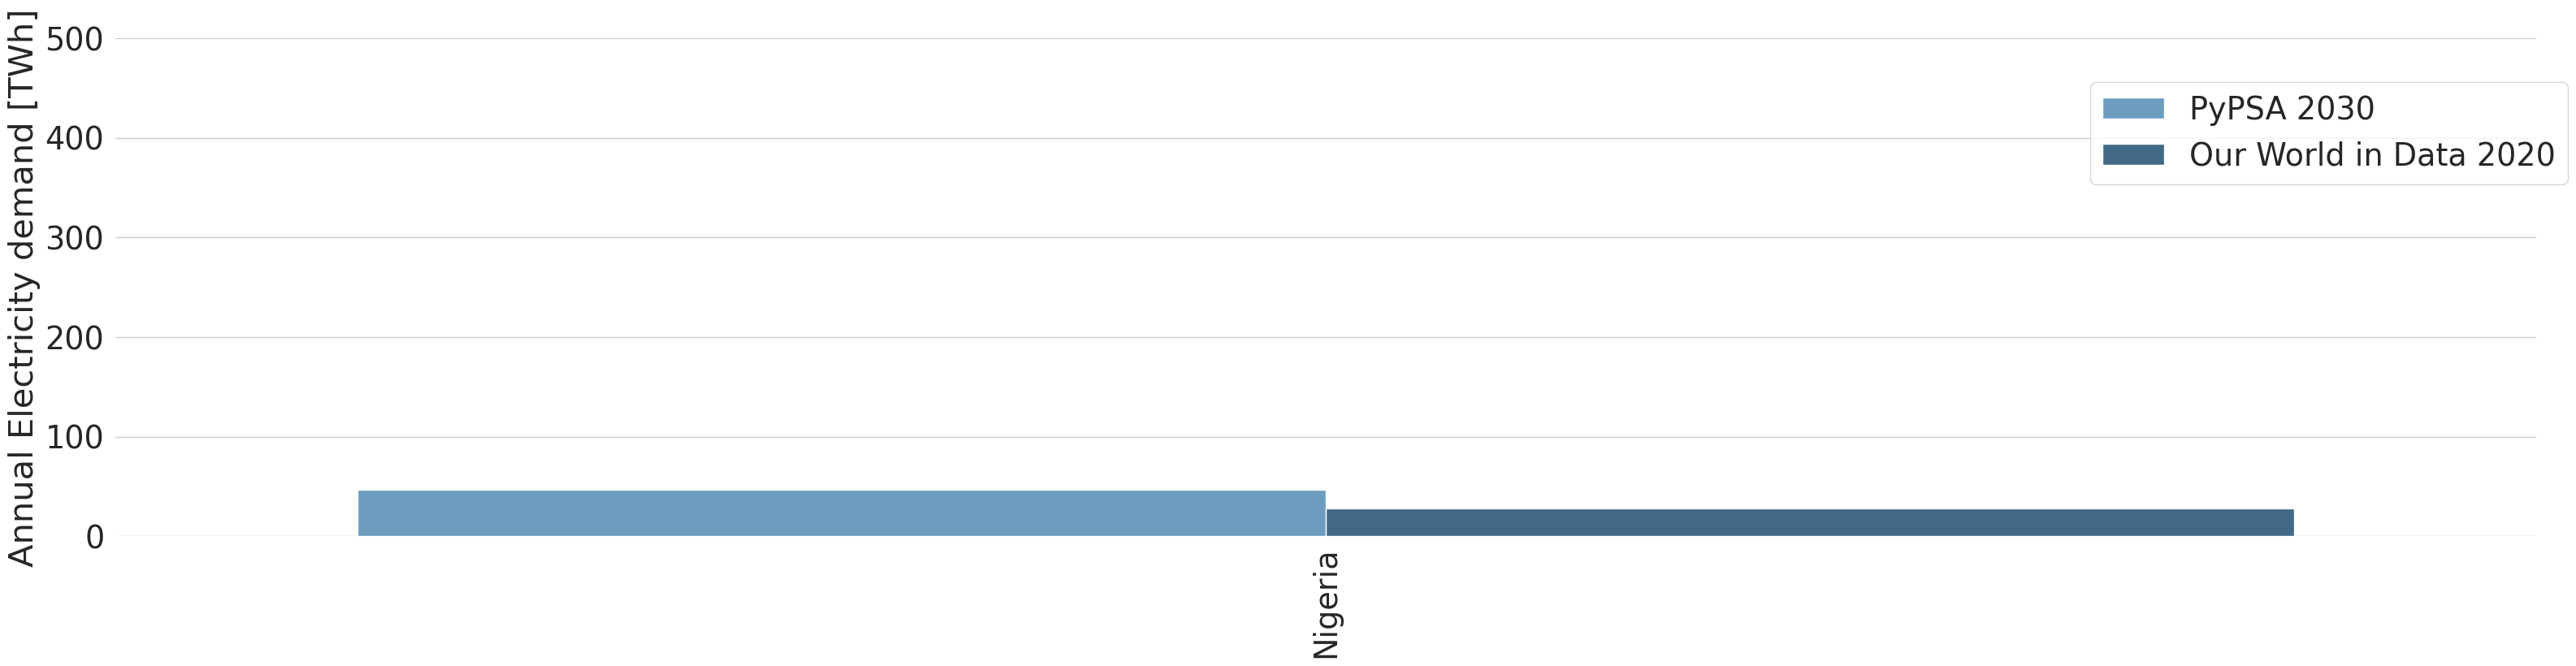

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt


sns.set_theme(style="whitegrid", font_scale=2.5)

# shorten names
df_merge.loc[df_merge["country"] == "Democratic Republic of Congo", "country"] = "DRC"
df_merge.loc[df_merge["country"] == "Central African Republic", "country"] = "CAR"

# split dataframe. No equal split possible since 'Our World in Data' misses "EH" == Western Sahara
df_merge1 = (
    df_merge.sort_values("country").iloc[0:46].sort_values("source", ascending=False)
)
df_merge2 = (
    df_merge.sort_values("country")
    .iloc[46:]
    .sort_values("source", ascending=False)
    .sort_values("country")
)

# Initialize the matplotlib figure
ax = sns.catplot(
    x="country",
    y="electricity_demand",
    hue="source",
    data=df_merge1,
    palette="Blues_d",
    kind="bar",
    height=8,
    aspect=4,
)
ax.set_xticklabels(rotation=90)
sns.move_legend(ax, "upper right", bbox_to_anchor=(0.85, 0.9), frameon=True, title=None)
sns.despine(left=True, bottom=True)
ax.set(xlabel=None, ylabel="Annual Electricity demand [TWh]", ylim=(0, 500))
ax.savefig("demand-validation-part1.pdf", bbox_inches="tight")

# ax = sns.catplot(
#    x="country",
#    y="electricity_demand",
#    hue="source",
#    data=df_merge2,
#    palette="Blues_d",
#    kind="bar",
#    height=8,
#    aspect=4,
#)
#ax.set_xticklabels(rotation=90)
#sns.move_legend(ax, "upper right", bbox_to_anchor=(0.85, 0.9), frameon=True, title=None)
#sns.despine(left=True, bottom=True)
#ax.set(xlabel=None, ylabel="Annual Electricity Demand [TWh]", ylim=(0, 500))
#ax.savefig("demand-validation-part2.pdf", bbox_inches="tight")


#sns.set_theme(style="whitegrid", font_scale=3.3)
#ax = sns.catplot(
#    x="country",
#    y="electricity_demand",
#    hue="source",
#    data=df_merge,
#    palette="Blues_d",
#    kind="bar",
#    height=8,
#    aspect=4,
#)

#ax.set_xticklabels(rotation=90)
#sns.move_legend(
#    ax, "upper right", bbox_to_anchor=(0.75, 0.94), frameon=True, title=None
#)
#sns.despine(left=True, bottom=False)
#ax.set(xlabel=None, ylabel="Electricity Demand [TWh/a]", ylim=(0, 500))
#ax.savefig("demand-validation-part.pdf", bbox_inches='tight')

/tmp/ipykernel_2333/4278182372.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_merge.groupby(by="source").sum().drop(columns="year").reset_index()


,source,electricity_demand
0,Our World in Data 2020,28.16
1,PyPSA 2030,46.44
0,IRENA 2030,1924.00
1,Alova et al. 2030,1877.00


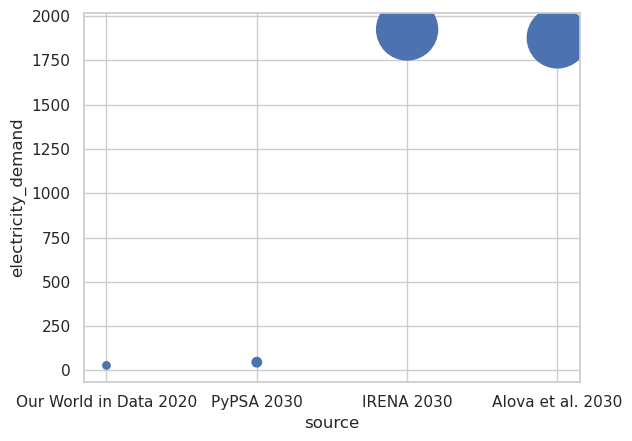

In [11]:
sns.set_theme(style="whitegrid", font_scale=1)

african_total_consumption = (
    df_merge.groupby(by="source").sum().drop(columns="year").reset_index()
)
extra = pd.DataFrame(
    data={
        "source": ["IRENA 2030", "Alova et al. 2030"],
        "electricity_demand": [1004 + 920, 1877],
    }
)
# https://www.irena.org/-/media/Files/IRENA/Agency/Publication/2015/IRENA_Africa_2030_REmap_2015_low-res.pdf
# https://www.nature.com/articles/s41560-020-00755-9

african_total_consumption = pd.concat([african_total_consumption, extra])
african_total_consumption.plot.scatter(
    x="source", y="electricity_demand", s="electricity_demand"
)
african_total_consumption